In [2]:
# importing modules I will use
import pandas as pd
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from itertools import combinations
import os
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.models import KeyedVectors
import string
from nltk.tokenize import RegexpTokenizer
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
device = torch.device('cuda:1') #if torch.cuda.is_available() else 'cpu')
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score


## MODEL

In [9]:
df = pd.read_csv('../data/df_subm.csv')

val_df = pd.read_csv('../data/val_subm.csv')
test_df = pd.read_csv('../data/test_subm.csv')
train_df = pd.read_csv('../data/train_subm.csv')

In [10]:
# I have the tensors saved locally, I can upload them on my repo too
# I usually start things from this point

val_tensors = torch.load('../data/val_subm.pt')
test_tensors = torch.load('../data/test_subm.pt')
train_tensors = torch.load('../data/train_subm.pt')

In [11]:
#df = pd.read_csv('/home/gusmavko@GU.GU.SE/aics-project/data/half_data.csv')
#
#train_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/train_half.csv")
#test_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/test_half.csv")
#val_df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/val_half.csv")

df['genres']=df['genres'].apply(lambda x: ast.literal_eval(x))

train_df['genres']=train_df['genres'].apply(lambda x: ast.literal_eval(x))
test_df['genres']=test_df['genres'].apply(lambda x: ast.literal_eval(x))
val_df['genres']=val_df['genres'].apply(lambda x: ast.literal_eval(x))


In [12]:
#df['production_companies']=df['production_companies'].apply(lambda x: ast.literal_eval(x))

train_df['production_companies']=train_df['production_companies'].apply(lambda x: ast.literal_eval(x))
test_df['production_companies']=test_df['production_companies'].apply(lambda x: ast.literal_eval(x))
val_df['production_companies']=val_df['production_companies'].apply(lambda x: ast.literal_eval(x))



In [13]:
train_df['production_companies']=train_df['production_companies'].apply(lambda x: (' ').join(x))
test_df['production_companies']=test_df['production_companies'].apply(lambda x: (' ').join(x))
val_df['production_companies']=val_df['production_companies'].apply(lambda x: (' ').join(x))

In [14]:
mlb = MultiLabelBinarizer()
# We need to pass a list of lists of the labels to get a one-hot encoding for the train, the test and the validation dataset.

# Fitting the multilabel binarizer to the labels available.
#print(mlb.fit(df['genres'].tolist()))

train_labels = mlb.fit_transform(train_df['genres'].tolist())
test_labels = mlb.fit_transform(test_df['genres'].tolist())
val_labels = mlb.fit_transform(val_df['genres'].tolist())

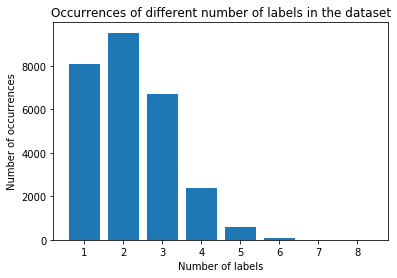

In [15]:
# This function creates a dictionary that has the number of movie labels as a key 
# and the number of occurrences of this number of labels as a value.

def plot_num_labels_movies(genre_lists):
    dic = {}
    for genre_list in genre_lists:
        if len(genre_list) in dic:
            dic[len(genre_list)] += 1
            
        else:
            dic[len(genre_list)] = 1
    return dic 

plot_dic = plot_num_labels_movies(df.genres.tolist())
plt.bar(*zip(*plot_dic.items()))
plt.title('Occurrences of different number of labels in the dataset')
plt.xlabel('Number of labels')
plt.ylabel('Number of occurrences')
plt.show()


In [16]:
swords = stopwords.words('english')
reg_ex_tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
#stemmer = Porter

# Thought about using different cleaning up methods for titles and summary.
def clean(text,is_for_summary=True):
    # removing punctuation and digits
    text = ''.join([c for c in text if c not in string.punctuation and not c.isdigit()])
    # tokenizing with the RegexpTokenizer and lowercasing the text
    text = reg_ex_tokenizer.tokenize(text.lower())
    # removing stop words if cleaning is applied on the overview - if we clean up the titles we keep the stop words since certain titles contain solely stop words(e.g. 'Who am I?').
    # maybe I should filter out stop words in titles too and only keep them when there are no other words.
    if is_for_summary:        
        text = [w for w in text if w not in swords]
    # lemmatizing the words with the WordNetLemmatizer and using join to put them back into a string
    text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    return text

In [17]:
# Cleaning up the orignal dataframe's overview and original_title column.
#df['overview'] = df['overview'].apply(lambda x: clean(x))
#df['original_title'] = df['original_title'].apply(lambda x: clean(x))
#df['production_companies'] =  df['production_companies'].apply(lambda x: clean(x))
# Cleaning up the overview column.
train_df['overview'] = train_df['overview'].apply(lambda x: clean(x))
test_df['overview'] = test_df['overview'].apply(lambda x: clean(x))
val_df['overview'] = val_df['overview'].apply(lambda x: clean(x))

# Cleaning up the original title column.
train_df['original_title'] = train_df['original_title'].apply(lambda x: clean(x,False))
test_df['original_title'] = test_df['original_title'].apply(lambda x: clean(x,False))
val_df['original_title'] = val_df['original_title'].apply(lambda x: clean(x,False))

# Cleaning up the production companies column.
train_df['production_companies'] = train_df['production_companies'].apply(lambda x: clean(x))
test_df['production_companies'] = test_df['production_companies'].apply(lambda x: clean(x))
val_df['production_companies'] = val_df['production_companies'].apply(lambda x: clean(x))


In [18]:
# Merging the three columns containing textual data into one to cover all possible occurrences for words.
df_tit_overview = df[['original_title','overview','production_companies']] 
df_vocab=df_tit_overview.stack().reset_index()
# Getting length of sequences for padding
max_len_for_padding = df_vocab[0].map(len).max()
#max_len_title_overview = df['title_and_overview'].map(len).max()
embedding_dim = 300
tokenizer = Tokenizer(num_words=50000, lower=True)
tokenizer.fit_on_texts(df_vocab[0].values)
# Creating a word to integer dictionary for my vocab.
word_index = tokenizer.word_index


In [19]:
len(word_index)


70173

In [20]:
def embed_vocab(pretrained_dict, vocab, emb_size):
    # creating a dictionary with keys the words and values the pretrained word vectors. 
    embeddings_index = {}
    for w in pretrained_dict.wv.vocab:
        embeddings_index[w] = pretrained_dict.word_vec(w)     
    # instantiating matrix with shape (vocab + 1, 300)
    embedding_matrix = 1 * np.random.randn(len(vocab)+1, emb_size)
    # looking up the words in my vocab
    for word, i in vocab.items():
        i-=1
        # getting the pretrained vector for the corresponding word
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # adding the vector to the matrix
            embedding_matrix[i] = embedding_vector                      
    del(embeddings_index)
        
    return embedding_matrix

# need to download the pretrained vectors file

w2v_dic = KeyedVectors.load_word2vec_format("/home/gusmavko@GU.GU.SE/aics-project/data/GoogleNews-vectors-negative300.bin", binary=True)
word2vec_matrix = embed_vocab(w2v_dic, word_index, 300)

    

/home/gusmavko@GU.GU.SE/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [60]:
# Transforming each word token from the textual data into the corresponding index. 
# TODO maybe when padding do I need to pad the titles to the same length as the overview 

X_overview_train = tokenizer.texts_to_sequences(train_df['overview'].values)
X_overview_train = pad_sequences(X_overview_train, maxlen=max_len_for_padding)

X_overview_test = tokenizer.texts_to_sequences(test_df['overview'].values)
X_overview_test = pad_sequences(X_overview_test, maxlen=max_len_for_padding)

X_overview_val = tokenizer.texts_to_sequences(val_df['overview'].values)
X_overview_val = pad_sequences(X_overview_val, maxlen=max_len_for_padding)

print(f'Train overview shape:{X_overview_train.shape}, Test overview shape:{X_overview_test.shape}, Validation overview shape:{X_overview_val.shape}')

Train overview shape:(19700, 800), Test overview shape:(5507, 800), Validation overview shape:(2195, 800)


In [29]:
# Tranforming the titles to integer representations.
df.original_title.apply(str)
max_len_title = train_df['original_title'].map(len).max()

# train title

X_title_train = tokenizer.texts_to_sequences(train_df['original_title'].values)
X_title_train = pad_sequences(X_title_train,maxlen=max_len_title)
# test title

X_title_test = tokenizer.texts_to_sequences(test_df['original_title'].values)
X_title_test = pad_sequences(X_title_test,maxlen=max_len_title)

# val title
X_title_val = tokenizer.texts_to_sequences(val_df['original_title'].values)
X_title_val = pad_sequences(X_title_val,maxlen=max_len_title)

print(f'Train title shape:{X_title_train.shape}, Test overview shape:{X_title_test.shape}, Validation overview shape:{X_title_val.shape}')

Train title shape:(19700, 93), Test overview shape:(5507, 93), Validation overview shape:(2195, 93)


In [30]:
# Changing the dimensions of the tensors for when passing them in batches to the model.
X_img_val = val_tensors.permute(0,3,1,2)

X_img_test = test_tensors.permute(0,3,1,2)

X_img_train = train_tensors.permute(0,3,1,2)

In [38]:
# using TensorDataset to transform the arrays into tensors for my overview title data

batch_size = 150
title_train_data = TensorDataset(torch.from_numpy(X_title_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))


title_val_data = TensorDataset(torch.from_numpy(X_title_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
title_test_data = TensorDataset(torch.from_numpy(X_title_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))



title_train_loader = DataLoader(title_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

title_val_loader = DataLoader(title_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

title_test_loader = DataLoader(title_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)

In [39]:
max_len_comp = 150#df['production_companies'].map(len).max()
X_company_train = tokenizer.texts_to_sequences(train_df['production_companies'].values)
X_company_train = pad_sequences(X_company_train, maxlen=max_len_comp)

X_company_test = tokenizer.texts_to_sequences(test_df['production_companies'].values)
X_company_test = pad_sequences(X_company_test, maxlen=max_len_comp)

X_company_val = tokenizer.texts_to_sequences(val_df['production_companies'].values)
X_company_val = pad_sequences(X_company_val, maxlen=max_len_comp)

#print(f'Train overview shape:{X_text_train.shape}, Test overview shape:{X_text_test.shape}, Validation overview shape:{X_text_val.shape}')

In [71]:
# using TensorDataset to transform the arrays into tensors for my overview textual data
text_train_data = TensorDataset(torch.from_numpy(X_overview_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))


text_val_data = TensorDataset(torch.from_numpy(X_overview_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
text_test_data = TensorDataset(torch.from_numpy(X_overview_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))


In [72]:

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)


In [42]:
# using TensorDataset to transform the arrays into tensors for my overview textual data
company_train_data = TensorDataset(torch.from_numpy(X_company_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))


company_val_data = TensorDataset(torch.from_numpy(X_company_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))
company_test_data = TensorDataset(torch.from_numpy(X_company_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))


In [43]:


company_train_loader = DataLoader(company_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

company_val_loader = DataLoader(company_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

company_test_loader = DataLoader(company_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)


## Title and Image

In [67]:
# Hyperparameters
batch_size = 150
epochs = 20
clip = 5
vocab_size = len(word_index)+1
output_size = train_labels.shape[1]
embedding_dim = 300
hidden_dim = 64
n_layers = 2
lr=0.001
criterion = nn.BCELoss()

In [147]:
# Building model for movie genre classification using textual and image features.
# CNN_LSTM2sc takes two features as input, The multimodal features can be either concatenated or summed. Change self.concat to False to sum.
class CNN_LSTM2sc(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out, concat=True):
        super(CNN_LSTM2sc, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        self.concat = concat
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        if self.concat == True:
            self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.         
            self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
            self.combined_fc2 = nn.Linear(256, 128)
            self.output_fc = nn.Linear(128, n_out)
        
        else:            
            self.cnn_fc = nn.Linear(4*4*128, 128) # when we sum, we want our textual and visual features to be of the same size so we can stack them
            # Concat layer for the combined feature space
            self.combined_fc1 = nn.Linear(128, 64) # Give me features of input.
            self.combined_fc2 = nn.Linear(64, 32)
            self.output_fc = nn.Linear(32, n_out)


    def forward(self, lstm_inp, cnn_inp):
        batch_size = lstm_inp.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_inp = lstm_inp.long()
        embeds = self.emb(lstm_inp)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))
        
        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        # that is how I get the correct dimensions for the CNN output that is then passed as input to the linear layer
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)
        x = self.cnn_dropout(x)
        
        if self.concat == True:
            cnn_out = F.relu(self.cnn_fc(x))            
            #concatenating the cnn output and the lstm output
            combined_inp = torch.cat((cnn_out, lstm_out), 1)
            # activation function
            x_comb = F.relu(self.combined_fc1(combined_inp))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # sigmoid to get probabilities for each label
            out = torch.sigmoid(self.output_fc(x_comb))
        else: # sum happens here
            cnn_out = F.relu(self.cnn_fc(x))            
            combined_inp = torch.stack([cnn_out, lstm_out], 1)            
            sum_comb = torch.sum(combined_inp,dim=1)           
            # activation function
            x_comb = F.relu(self.combined_fc1(sum_comb))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # sigmoid to get probabilities for each label
            out = torch.sigmoid(self.output_fc(x_comb))     
                              
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [155]:
# Building model for movie genre classification using textual and image features.
# CNN_LSTM3sc takes three features as input. The multimodal features can be either concatenated or summed. Change self.concat to False to sum.
class CNN_LSTM3sc(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out, concat=True):
        super(CNN_LSTM3sc, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        self.concat = concat
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        if self.concat == True:
            self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.
        # Concat layer for the combined feature space
            self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
            self.combined_fc2 = nn.Linear(256, 128)
            self.output_fc = nn.Linear(128, n_out)        
        else:            
            self.cnn_fc = nn.Linear(4*4*128, 128) # when we sum, we want our textual and visual features to be of the same size so we can stack them
            # Concat layer for the combined feature space
            self.combined_fc1 = nn.Linear(128, 64) # Give me features of input.
            self.combined_fc2 = nn.Linear(64, 32)
            self.output_fc = nn.Linear(32, n_out)

    def forward(self, lstm_in, cnn_inp, title_inp):
        batch_size = lstm_in.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_in = lstm_in.long()
        title_inp = title_inp.long()
        embeds_lstm = self.emb(lstm_in)
        embeds_title = self.emb(title_inp)
        embeds = torch.cat((embeds_lstm,embeds_title),dim=1)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))
       
        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)        
        x = self.cnn_dropout(x)        
        if self.concat == True: # concatenate the multimodal features
            cnn_out = F.relu(self.cnn_fc(x))            
            #concatenating the cnn output and the lstm output
            combined_inp = torch.cat((cnn_out, lstm_out), 1)
            # activation function
            x_comb = F.relu(self.combined_fc1(combined_inp))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # sigmoid to get probabilities for each label
            out = torch.sigmoid(self.output_fc(x_comb))
        else: # sum the multimodal features
            cnn_out = F.relu(self.cnn_fc(x))
            # sum happens here
            combined_inp = torch.stack([cnn_out, lstm_out], 1)            
            sum_comb = torch.sum(combined_inp,dim=1)
            # activation function
            x_comb = F.relu(self.combined_fc1(sum_comb))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # # sigmoid to get probabilities for each label
            out = torch.sigmoid(self.output_fc(x_comb))     
                              
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [154]:
# Building model for movie genre classification using textual and image features.
# CNN_LSTM4sc takes four features as input. The multimodal features can be either concatenated or summed. Change self.concat to False to sum.
class CNN_LSTM4sc(nn.Module):
    def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out, concat=True):
        super(CNN_LSTM4sc, self).__init__()

        # LSTM for the text overview
        self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
        num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
        self.emb.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.lstm_fc = nn.Linear(self.n_hidden, 128)
        self.concat = concat
        
        # CNN for the posters
        self.conv1 = nn.Conv2d(3, 32, 3) # Gives me depth of input.
        # pooling layers to reduce the image size
        self.max_pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.max_pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.max_pool4 = nn.MaxPool2d(2)
        # to drop the nodes that are below the wanted weights
        self.cnn_dropout = nn.Dropout(0.1)
        if self.concat == True: # concatenate the multimodal features
            self.cnn_fc = nn.Linear(4*4*128, 512) # Gives me number of features of input.  
            # Concat layer for the combined feature space
            self.combined_fc1 = nn.Linear(640, 256) # Give me features of input.
            self.combined_fc2 = nn.Linear(256, 128)
            self.output_fc = nn.Linear(128, n_out)        
        else:   # sum the multimodal features
            self.cnn_fc = nn.Linear(4*4*128, 128) # when we sum, we want our textual and visual features to be of the same size so we can stack them
            # Concat layer for the combined feature space
            self.combined_fc1 = nn.Linear(128, 64) # Give me features of input.
            self.combined_fc2 = nn.Linear(64, 32)
            self.output_fc = nn.Linear(32, n_out)


    def forward(self, lstm_in, cnn_inp, title_inp, company_inp):
        batch_size = lstm_in.size(0)
        hidden = self.init_hidden(batch_size)
        lstm_in, title_inp,company_inp = lstm_in.long(), title_inp.long(), company_inp.long()
        embeds_lstm = self.emb(lstm_in)
        embeds_title = self.emb(title_inp)
        embeds_company = self.emb(company_inp)
        embeds = torch.cat((embeds_lstm,embeds_title,embeds_company),dim=1)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = self.dropout(lstm_out[:, -1])
        lstm_out = F.relu(self.lstm_fc(lstm_out))

        x = F.relu(self.conv1(cnn_inp))
        x = self.max_pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        
        x = F.relu(self.conv4(x))
        x = self.max_pool4(x)
        # that is how I get the correct dimensions for the CNN output that is then passed as input to the linear layer
        # need the input to be two dimensional again
        x = x.view(-1, 4*4*128)
        
        x = self.cnn_dropout(x)
        if self.concat == True: # concatenate the multimodal features
            cnn_out = F.relu(self.cnn_fc(x))            
            #concatenating the cnn output and the lstm output
            combined_inp = torch.cat((cnn_out, lstm_out), 1)
            # activation function
            x_comb = F.relu(self.combined_fc1(combined_inp))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # sigmoid to get probabilities for each label
            out = torch.sigmoid(self.output_fc(x_comb))
        else: # sum the multimodal features
            cnn_out = F.relu(self.cnn_fc(x))
            combined_inp = torch.stack([cnn_out, lstm_out], 1)            
            sum_comb = torch.sum(combined_inp,dim=1)
            # activation function
            x_comb = F.relu(self.combined_fc1(sum_comb))
            x_comb = F.relu(self.combined_fc2(x_comb))
            # sigmoid to get 1 and 0 on the one-hot-encoding formatted label
            out = torch.sigmoid(self.output_fc(x_comb))     
                              
        return out

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [148]:
device = torch.device('cuda:2')
model_title_sum = CNN_LSTM2sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size,False)
model_title_sum.to(device)
train_val(model_title_sum,epochs, title_train_loader, img_train_loader,criterion, title_val_loader, img_val_loader, 2,1)

done training tensor(0.8041, device='cuda:2')
Saving model...
Epoch 1: train_loss: 0.3321 train_acc: 0.8041 | val_loss: 0.3092 val_acc: 0.8385
done training tensor(0.8213, device='cuda:2')
Saving model...
Epoch 2: train_loss: 0.3056 train_acc: 0.8213 | val_loss: 0.2995 val_acc: 0.8239
done training tensor(0.8237, device='cuda:2')
Saving model...
Epoch 3: train_loss: 0.3014 train_acc: 0.8237 | val_loss: 0.2958 val_acc: 0.8290
done training tensor(0.8262, device='cuda:2')
Saving model...
Epoch 4: train_loss: 0.2972 train_acc: 0.8262 | val_loss: 0.2929 val_acc: 0.8310
done training tensor(0.8273, device='cuda:2')
Saving model...
Epoch 5: train_loss: 0.2952 train_acc: 0.8273 | val_loss: 0.2949 val_acc: 0.8343
done training tensor(0.8285, device='cuda:2')
Saving model...
Epoch 6: train_loss: 0.2931 train_acc: 0.8285 | val_loss: 0.2934 val_acc: 0.8339
done training tensor(0.8303, device='cuda:2')
Saving model...
Epoch 7: train_loss: 0.2898 train_acc: 0.8303 | val_loss: 0.2916 val_acc: 0.8359

In [160]:
model_title = CNN_LSTM2sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model_title.to(device)

CNN_LSTM2sc(
  (emb): Embedding(70174, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, 

In [119]:
# num_feats can be either 2,3 or 4, i.e. the number of different features (overview, title,
# companies, poster are the possible features) used as input to the model.
# model_num is just a random integer to save the models we train.
def train_val(model,epochs, t_train_loader, image_train_loader, criterion, t_val_loader, image_val_loader, num_feats, model_num):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    model.train()
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0        
        for lstm, cnn in zip(t_train_loader, image_train_loader):
            cnn_inp, cnn_labels = cnn
            cnn_inp = cnn_inp.float()
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            if num_feats == 2:
                lstm_inp,lstm_labels = lstm
                lstm_inp = lstm_inp.float()                
                lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)                
                model.zero_grad()
                output = model(lstm_inp, cnn_inp)                
            elif num_feats == 3:
                lstm_inp, title_inp, lstm_labels = lstm        
                title_inp = title_inp.float()
                lstm_inp = lstm_inp.float()               
                lstm_inp = lstm_inp.to(device)
                title_inp = title_inp.to(device)
                lstm_labels =  lstm_labels.to(device)      
                model.zero_grad()
                output = model(lstm_inp, cnn_inp, title_inp)                
            else:
                lstm_inp, title_inp, company_inp, lstm_labels = lstm
                lstm_inp = lstm_inp.float()
                title_inp = title_inp.float()
                company_inp = company_inp.float()                
                lstm_inp, title_inp, company_inp,lstm_labels = lstm_inp.to(device),title_inp.to(device), company_inp.to(device), lstm_labels.to(device)
                
                model.zero_grad()
                output = model(lstm_inp, cnn_inp, title_inp,company_inp)
                
            loss = criterion(output.squeeze(), lstm_labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        
            with torch.no_grad():
                acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
                acc = (1. - acc.sum() / acc.size()[0])
                total_acc_train += acc
                total_loss_train += loss.item()
      
        train_acc = total_acc_train/len(t_train_loader)
        train_loss = total_loss_train/len(t_train_loader)
        print('done training',train_acc)
        model.eval()
        total_acc_val = 0
        total_loss_val = 0
        with torch.no_grad():
            for lstm, cnn in zip(t_val_loader, image_val_loader):
                cnn_inp, cnn_labels = cnn
                cnn_inp = cnn_inp.float()
                cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
                if num_feats == 2:
                    lstm_inp,lstm_labels = lstm
                    lstm_inp = lstm_inp.float()                
                    lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)                
                    model.zero_grad()
                    output = model(lstm_inp, cnn_inp) 
                elif num_feats == 3:
                    lstm_inp, title_inp, lstm_labels = lstm        
                    title_inp = title_inp.float()
                    lstm_inp = lstm_inp.float()               
                    lstm_inp = lstm_inp.to(device)
                    title_inp = title_inp.to(device)
                    lstm_labels =  lstm_labels.to(device)      
                    model.zero_grad()
                    output = model(lstm_inp, cnn_inp,title_inp)
                else:
                    lstm_inp, title_inp, company_inp, lstm_labels = lstm
                    lstm_inp = lstm_inp.float()
                    title_inp = title_inp.float()
                    company_inp = company_inp.float()                
                    lstm_inp, title_inp, company_inp,lstm_labels = lstm_inp.to(device),title_inp.to(device), company_inp.to(device), lstm_labels.to(device)
                    model.zero_grad()
                    output = model(lstm_inp, cnn_inp, title_inp,company_inp)
                    
                    
                val_loss = criterion(output.squeeze(), lstm_labels.float())
                acc = torch.abs(output.squeeze() - lstm_labels.float()).view(-1)
                acc = (1. - acc.sum() / acc.size()[0])
                total_acc_val += acc
                total_loss_val += val_loss.item()
        print("Saving model...") 
        # 10 diff models to save
        if model_num == 0:
            torch.save(model_title.state_dict(), '../data/models/model0.pt')
        elif model_num == 1:
            torch.save(model_title.state_dict(), '../data/models/model1.pt')    
        elif model_num == 2:
            torch.save(model_title.state_dict(), '../data/models/model2.pt')
        elif model_num == 3:
            torch.save(model_title.state_dict(), '../data/models/model3.pt')
        elif model_num == 4:
            torch.save(model_title.state_dict(), '../data/models/model4.pt')
        elif model_num == 5:
            torch.save(model_title.state_dict(), '../data/models/model5.pt')
        elif model_num == 6:
            torch.save(model_title.state_dict(), '../data/models/model6.pt')
        elif model_num == 7:
            torch.save(model_title.state_dict(), '../data/models/model7.pt')
        elif model_num == 8:
            torch.save(model_title.state_dict(), '../data/models/model8.pt')
        elif model_num == 9:
            torch.save(model_title.state_dict(), '../data/models/model9.pt')
    
        val_acc = total_acc_val/len(t_val_loader)
        val_loss = total_loss_val/len(t_val_loader)
        print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        model.train()

In [55]:
train_val(model_title,epochs, title_train_loader, img_train_loader,criterion, title_val_loader, img_val_loader, 2,1)

done training tensor(0.8140, device='cuda:1')
Saving model_title...
Epoch 1: train_loss: 0.3167 train_acc: 0.8140 | val_loss: 0.3006 val_acc: 0.8334
done training tensor(0.8235, device='cuda:1')
Saving model_title...
Epoch 2: train_loss: 0.3018 train_acc: 0.8235 | val_loss: 0.2957 val_acc: 0.8315
done training tensor(0.8258, device='cuda:1')
Saving model_title...
Epoch 3: train_loss: 0.2980 train_acc: 0.8258 | val_loss: 0.2941 val_acc: 0.8351
done training tensor(0.8282, device='cuda:1')
Saving model_title...
Epoch 4: train_loss: 0.2932 train_acc: 0.8282 | val_loss: 0.2898 val_acc: 0.8334
done training tensor(0.8317, device='cuda:1')
Saving model_title...
Epoch 5: train_loss: 0.2870 train_acc: 0.8317 | val_loss: 0.2902 val_acc: 0.8369
done training tensor(0.8351, device='cuda:1')
Saving model_title...
Epoch 6: train_loss: 0.2809 train_acc: 0.8351 | val_loss: 0.2872 val_acc: 0.8337
done training tensor(0.8385, device='cuda:1')
Saving model_title...
Epoch 7: train_loss: 0.2750 train_acc:

In [56]:
# This function returns accuracy and roc auc score of a model on the test set.
def test_acc_auc(model,text_test_loader, img_test_loader, criterion,num_feats):
    model.eval()
    correct = 0
    total = 0
    total_acc_test = 0
    total_loss_test = 0
    outputs = []
    with torch.no_grad():
        for lstm, cnn in zip(text_test_loader, img_test_loader):
            cnn_inp, cnn_labels = cnn
            cnn_inp = cnn_inp.float()
            cnn_inp, cnn_labels = cnn_inp.to(device), cnn_labels.to(device)
            if num_feats == 2:
                lstm_inp, lstm_labels = lstm
                lstm_inp = lstm_inp.float()
                
                lstm_inp, lstm_labels = lstm_inp.to(device), lstm_labels.to(device)
                
                out = model(lstm_inp, cnn_inp)
            elif num_feats == 3:
                lstm_inp, title_inp, lstm_labels = lstm
                lstm_inp = lstm_inp.float()
                title_inp = title_inp.float()
                lstm_inp, title_inp,lstm_labels = lstm_inp.to(device),title_inp.to(device), lstm_labels.to(device)
                out = model(lstm_inp, cnn_inp,title_inp)
            else:
                lstm_inp, title_inp, company_inp, lstm_labels = lstm
                lstm_inp = lstm_inp.float()
                title_inp = title_inp.float()
                company_inp = company_inp.float()                
                lstm_inp, title_inp, company_inp, lstm_labels = lstm_inp.to(device), title_inp.to(device), company_inp.to(device),  lstm_labels.to(device)                
                out = model(lstm_inp, cnn_inp, title_inp, company_inp)
                
            
                  
            outputs += list(out.cpu().data.numpy())
            loss = criterion(out.squeeze(), lstm_labels.float())
            acc = torch.abs(out.squeeze() - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_test += acc
            total_loss_test += loss.item()
    
    acc_test = total_acc_test/len(title_test_loader)
    loss_test = total_loss_test/len(title_test_loader)        
    
    np_out = np.array(outputs)
    y_pred = np.zeros(np_out.shape)
    y_pred[np_out>0.5]= 1 # threshold to assign a label is a probability of 0.5.
    y_pred = np.array(y_pred)    
    preds = np.transpose(y_pred)
    labels = np.transpose(test_labels)
    roc_auc = roc_auc_score(labels, preds) # calculating ROC-AUC score
    print(f'acc: {acc_test:.4f}, loss: {loss_test:.4f}, roc auc: {roc_auc}')
    return acc_test, roc_auc

In [57]:
test_acc_auc(model_title, title_test_loader, img_test_loader, criterion,2)

acc: 0.8462 loss: 0.3624 roc auc: 0.6462277587954535


(tensor(0.8462, device='cuda:1'), 0.6462277587954535)

## Overview and Image

In [161]:
model_overview = CNN_LSTM2sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model_overview.to(device)

CNN_LSTM2sc(
  (emb): Embedding(70174, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, 

In [97]:
train_val(model_overview, epochs, text_train_loader, img_train_loader,criterion, text_val_loader, img_val_loader, 2,2)


## Attempt at using title, image, poster as input

In [119]:
# Attempting to add title when loading the dataset.
# Again, using TensorDataset to transform the arrays into tensors for my textual data.

# train dataset
text_train_data = TensorDataset(torch.from_numpy(X_overview_train), torch.from_numpy(X_title_train), torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))

# validation dataset
text_val_data = TensorDataset(torch.from_numpy(X_overview_val), torch.from_numpy(X_title_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))

# test dataset
text_test_data = TensorDataset(torch.from_numpy(X_overview_test),torch.from_numpy(X_title_test), torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))

batch_size = 150

text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)
 #using TensorDataset to transform the arrays into tensors for my overview textual data


In [90]:
model3 = CNN_LSTM3sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model3.to(device)


CNN_LSTM3(
  (emb): Embedding(70174, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm_fc): Linear(in_features=64, out_features=128, bias=True)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (max_pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn_dropout): Dropout(p=0.1, inplace=False)
  (cnn_fc): Linear(in_features=2048, out_features=512, bias=True)
  (combined_fc1): Linear(in_features=640, out_features=256, bi

## Companies and Image

In [81]:
model_comp = CNN_LSTM2(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model_comp.to(device)
train_val(model_comp, epochs, company_train_loader, img_train_loader,criterion, company_val_loader, img_val_loader, 2,4)


done training tensor(0.8145, device='cuda:1')
Saving model...
Epoch 1: train_loss: 0.3171 train_acc: 0.8145 | val_loss: 0.3022 val_acc: 0.8325
done training tensor(0.8236, device='cuda:1')
Saving model...
Epoch 2: train_loss: 0.3015 train_acc: 0.8236 | val_loss: 0.2980 val_acc: 0.8391
done training tensor(0.8261, device='cuda:1')
Saving model...
Epoch 3: train_loss: 0.2970 train_acc: 0.8261 | val_loss: 0.2909 val_acc: 0.8326
done training tensor(0.8299, device='cuda:1')
Saving model...
Epoch 4: train_loss: 0.2899 train_acc: 0.8299 | val_loss: 0.2877 val_acc: 0.8357
done training tensor(0.8338, device='cuda:1')
Saving model...
Epoch 5: train_loss: 0.2832 train_acc: 0.8338 | val_loss: 0.2836 val_acc: 0.8372
done training tensor(0.8371, device='cuda:1')
Saving model...
Epoch 6: train_loss: 0.2770 train_acc: 0.8371 | val_loss: 0.2831 val_acc: 0.8406
done training tensor(0.8402, device='cuda:1')
Saving model...
Epoch 7: train_loss: 0.2714 train_acc: 0.8402 | val_loss: 0.2853 val_acc: 0.8442

In [98]:
test_acc_auc(model_comp, company_test_loader, img_test_loader, criterion,2)

acc: 0.8485 loss: 0.3577 roc auc: 0.6495766034899384


(tensor(0.8485, device='cuda:1'), 0.6495766034899384)

## Model that takes overview, title, production companies & poster as input

In [151]:
# train dataset
text_train_data = TensorDataset(torch.from_numpy(X_overview_train), torch.from_numpy(X_title_train), torch.from_numpy(X_company_train),torch.from_numpy(train_labels))
img_train_data = TensorDataset(X_img_train, torch.from_numpy(train_labels))

# validation dataset
text_val_data = TensorDataset(torch.from_numpy(X_overview_val), torch.from_numpy(X_title_val),torch.from_numpy(X_company_val), torch.from_numpy(val_labels))
img_val_data = TensorDataset(X_img_val, torch.from_numpy(val_labels))

# test dataset
text_test_data = TensorDataset(torch.from_numpy(X_overview_test),torch.from_numpy(X_title_test), torch.from_numpy(X_company_test),torch.from_numpy(test_labels))
img_test_data = TensorDataset(X_img_test, torch.from_numpy(test_labels))


text_train_loader = DataLoader(text_train_data, batch_size=batch_size)
img_train_loader = DataLoader(img_train_data, batch_size=batch_size)

text_val_loader = DataLoader(text_val_data, batch_size=batch_size)
img_val_loader = DataLoader(img_val_data, batch_size=batch_size)

text_test_loader = DataLoader(text_test_data, batch_size=batch_size)
img_test_loader = DataLoader(img_test_data, batch_size=batch_size)
 #using TensorDataset to transform the arrays into tensors for my overview textual data

In [101]:
model4 = CNN_LSTM4sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size)
model4.to(device)
train_val(model4, epochs, text_train_loader, img_train_loader, criterion, text_val_loader, img_val_loader, 4,5)


done training tensor(0.8142, device='cuda:1')
Saving model...
Epoch 1: train_loss: 0.3170 train_acc: 0.8142 | val_loss: 0.3002 val_acc: 0.8300
done training tensor(0.8236, device='cuda:1')
Saving model...
Epoch 2: train_loss: 0.3018 train_acc: 0.8236 | val_loss: 0.2958 val_acc: 0.8334
done training tensor(0.8264, device='cuda:1')
Saving model...
Epoch 3: train_loss: 0.2965 train_acc: 0.8264 | val_loss: 0.2955 val_acc: 0.8389
done training tensor(0.8299, device='cuda:1')
Saving model...
Epoch 4: train_loss: 0.2902 train_acc: 0.8299 | val_loss: 0.2875 val_acc: 0.8377
done training tensor(0.8338, device='cuda:1')
Saving model...
Epoch 5: train_loss: 0.2830 train_acc: 0.8338 | val_loss: 0.2865 val_acc: 0.8377
done training tensor(0.8370, device='cuda:1')
Saving model...
Epoch 6: train_loss: 0.2773 train_acc: 0.8370 | val_loss: 0.2847 val_acc: 0.8382
done training tensor(0.8401, device='cuda:1')
Saving model...
Epoch 7: train_loss: 0.2716 train_acc: 0.8401 | val_loss: 0.2862 val_acc: 0.8403

In [158]:
model4sum = CNN_LSTM4sc(vocab_size, word2vec_matrix, hidden_dim, n_layers, output_size,concat=False) # try summing
model4sum.to(device)
train_val(model4sum, epochs, text_train_loader, img_train_loader, criterion, text_val_loader, img_val_loader, 4,7)


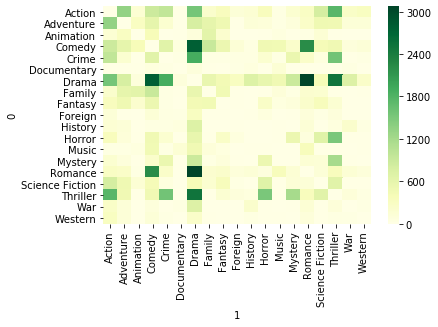

In [95]:
#action, comedy, crime, drama the lowest, horror, romance, thriller

l = df.genres.values

c = [list(combinations(i,2)) for i in l]
a = list(itertools.chain.from_iterable((i, i[::-1]) for c_ in c for i in c_))
dft = pd.DataFrame(a)
aba=pd.pivot_table(dft, index=0, columns=1, aggfunc='size', fill_value=0)
sns.heatmap(aba,cmap="YlGn")